In [111]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import joblib
import re
import nltk
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/spartan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [112]:
# Load datasets
fake_news = pd.read_csv('/Users/spartan/Downloads/archive (2)/Fake.csv')
true_news = pd.read_csv('/Users/spartan/Downloads/archive (2)/True.csv')

# Find duplicate rows in both datasets
fake_news_duplicates = fake_news[fake_news.duplicated()]
true_news_duplicates = true_news[true_news.duplicated()]

# Display the number of duplicate rows found
print(f"Number of duplicate rows in Fake News dataset: {len(fake_news_duplicates)}")
print(f"Number of duplicate rows in True News dataset: {len(true_news_duplicates)}")

# Optionally, display the duplicate rows for inspection
print("Duplicate rows in Fake News dataset:")
print(fake_news_duplicates)

print("\nDuplicate rows in True News dataset:")
print(true_news_duplicates)

Number of duplicate rows in Fake News dataset: 3
Number of duplicate rows in True News dataset: 206
Duplicate rows in Fake News dataset:
                                                   title  \
9942   HILLARY TWEETS MESSAGE In Defense Of DACA…OOPS...   
11446  FORMER DEMOCRAT WARNS Young Americans: “Rioter...   
14925  [VIDEO] #BlackLivesMatter Terrorists Storm Dar...   

                                                    text   subject  \
9942   No time to waste   we've got to fight with eve...  politics   
11446   Who is silencing political speech, physically...  politics   
14925  They were probably just looking for a  safe sp...  politics   

               date  
9942    Sep 9, 2017  
11446  Mar 10, 2017  
14925  Nov 16, 2015  

Duplicate rows in True News dataset:
                                                   title  \
445    Senate tax bill stalls on deficit-focused 'tri...   
778    Trump warns 'rogue regime' North Korea of grav...   
892    Republicans unveil tax cut b

In [113]:
# Analyze duplicates
fake_duplicates = fake_news.duplicated().sum()
true_duplicates = true_news.duplicated().sum()

# Create summary DataFrame
summary = pd.DataFrame({
    'Dataset': ['Fake News', 'True News'],
    'Total Rows': [len(fake_news), len(true_news)],
    'Duplicate Rows': [fake_duplicates, true_duplicates],
    'Unique Rows': [len(fake_news) - fake_duplicates, len(true_news) - true_duplicates]
})

print(summary)

     Dataset  Total Rows  Duplicate Rows  Unique Rows
0  Fake News       23481               3        23478
1  True News       21417             206        21211


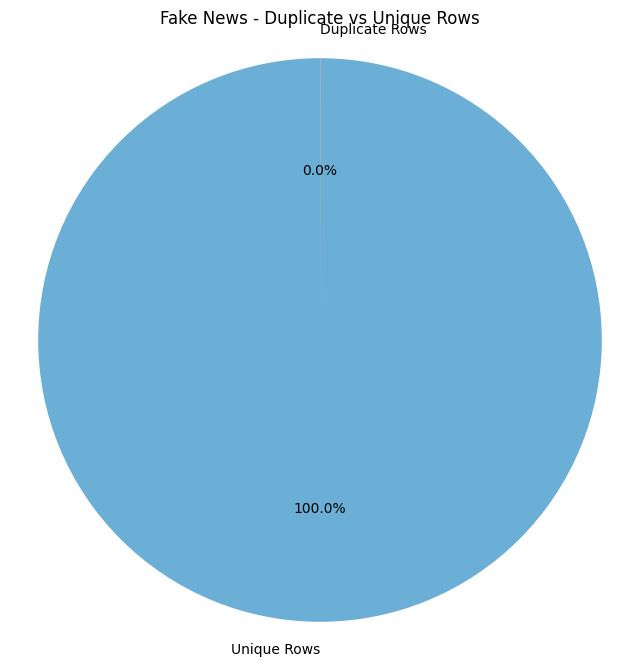

In [114]:
# Pie chart for Fake News
labels = ['Unique Rows', 'Duplicate Rows']
sizes = [summary.loc[0, 'Unique Rows'], summary.loc[0, 'Duplicate Rows']]  # Fake News data
colors = ['#6baed6', '#ff6f61']
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Fake News - Duplicate vs Unique Rows')
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle
plt.show()


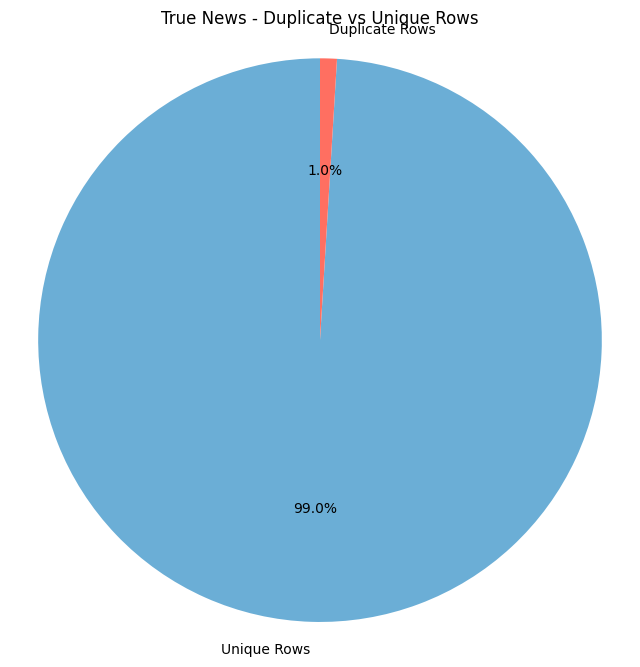

In [115]:
# Pie chart for True News
labels = ['Unique Rows', 'Duplicate Rows']
sizes = [summary.loc[1, 'Unique Rows'], summary.loc[1, 'Duplicate Rows']]  # True News data
colors = ['#6baed6', '#ff6f61']

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('True News - Duplicate vs Unique Rows')
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle
plt.show()

In [116]:
# Drop duplicate rows from both datasets
fake_news = fake_news.drop_duplicates()
true_news = true_news.drop_duplicates()

# Verify the number of rows after removing duplicates
print(f"Rows in Fake News after dropping duplicates: {len(fake_news)}")
print(f"Rows in True News after dropping duplicates: {len(true_news)}")


Rows in Fake News after dropping duplicates: 23478
Rows in True News after dropping duplicates: 21211


In [117]:
# Create a 'word_count' column for both datasets
fake_news['word_count'] = fake_news['text'].apply(lambda x: len(str(x).split()))
true_news['word_count'] = true_news['text'].apply(lambda x: len(str(x).split()))

# Display the updated DataFrames
print(fake_news[['title','subject', 'word_count']].head())
print(true_news[['title','subject', 'word_count']].head())


                                               title subject  word_count
0   Donald Trump Sends Out Embarrassing New Year’...    News         495
1   Drunk Bragging Trump Staffer Started Russian ...    News         305
2   Sheriff David Clarke Becomes An Internet Joke...    News         580
3   Trump Is So Obsessed He Even Has Obama’s Name...    News         444
4   Pope Francis Just Called Out Donald Trump Dur...    News         420
                                               title       subject  word_count
0  As U.S. budget fight looms, Republicans flip t...  politicsNews         749
1  U.S. military to accept transgender recruits o...  politicsNews         624
2  Senior U.S. Republican senator: 'Let Mr. Muell...  politicsNews         457
3  FBI Russia probe helped by Australian diplomat...  politicsNews         376
4  Trump wants Postal Service to charge 'much mor...  politicsNews         852


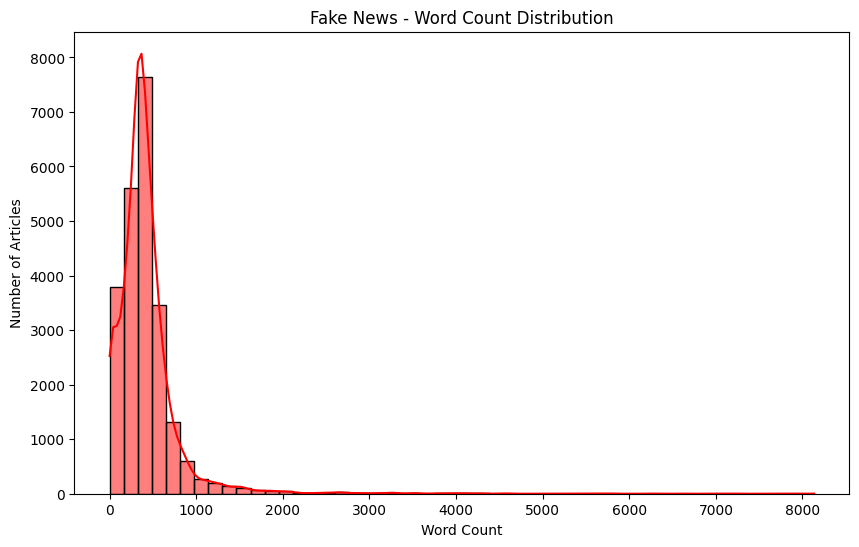

In [118]:
# Word count distribution for fake news
plt.figure(figsize=(10, 6))
sns.histplot(fake_news['word_count'], bins=50, kde=True, color='red')
plt.title('Fake News - Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Number of Articles')
plt.show()

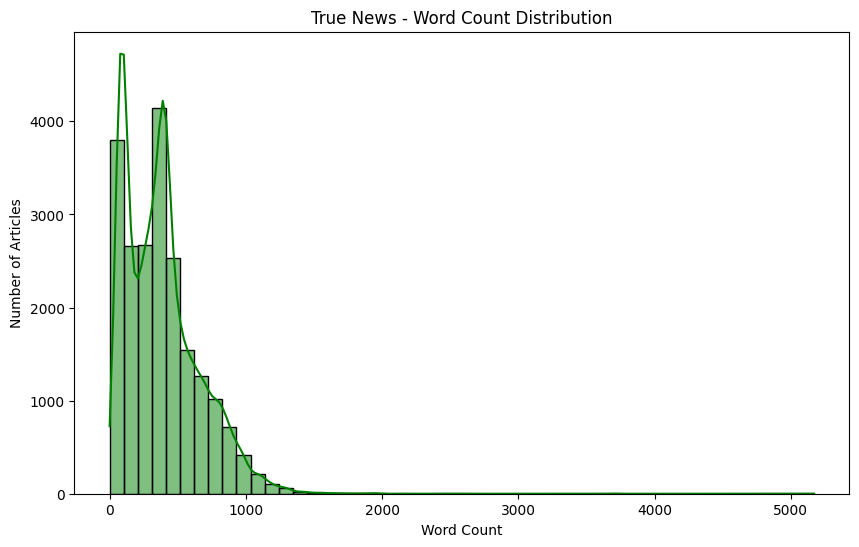

In [119]:
# Word count distribution for true news
plt.figure(figsize=(10, 6))
sns.histplot(true_news['word_count'], bins=50, kde=True, color='green')
plt.title('True News - Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Number of Articles')
plt.show()

In [120]:
# Label the data
fake_news['label'] = 0
true_news['label'] = 1

# Combine the data
data = pd.concat([fake_news, true_news], ignore_index=True)

In [121]:
data['label'].value_counts()

label
0    23478
1    21211
Name: count, dtype: int64

In [122]:
data.head(6)

,title,text,subject,date,word_count,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",495,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",305,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",580,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",444,0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",420,0
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017",312,0


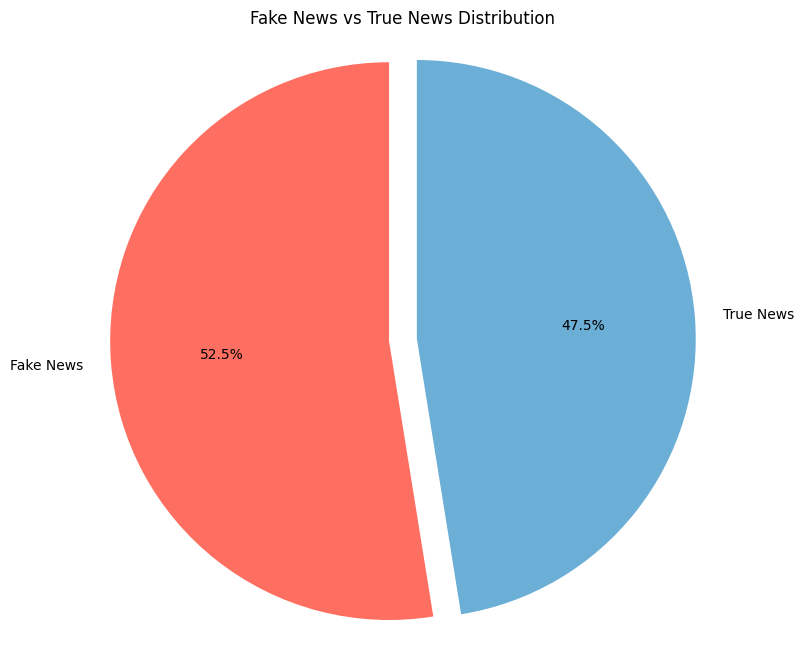

In [123]:
# Prepare data for Fake News vs True News distribution
labels = ['Fake News', 'True News']
sizes = [len(fake_news), len(true_news)]  # Number of rows in each dataset
colors = ['#ff6f61', '#6baed6'] 
explode = (0.1, 0)  

# Create pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%', startangle=90)
plt.title('Fake News vs True News Distribution')
plt.axis('equal') 
plt.show()


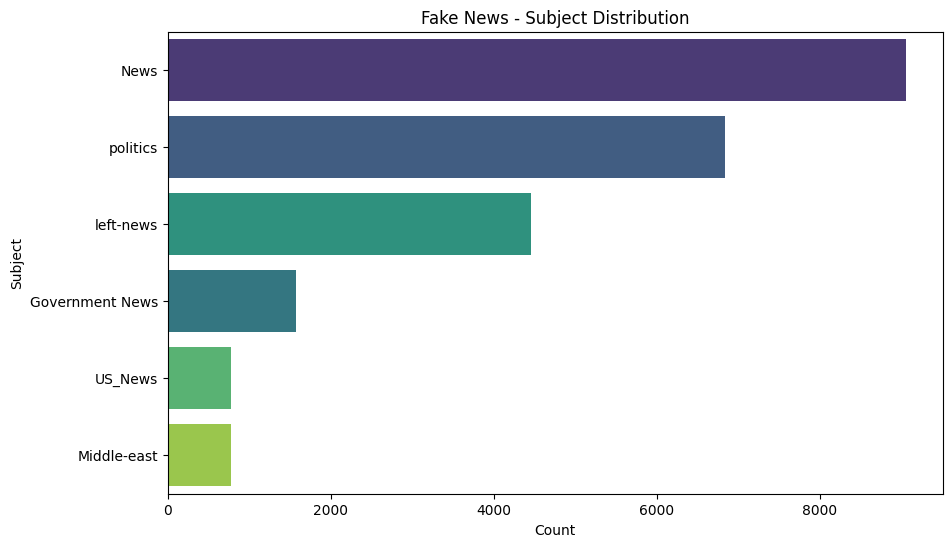

In [124]:
# Subject distribution for fake news with custom colors
plt.figure(figsize=(10, 6))
sns.countplot(
    y='subject',
    data=fake_news,
    order=fake_news['subject'].value_counts().index,
    hue='subject',  
    dodge=False,    
    palette="viridis" 
)
plt.legend([], [], frameon=False) 
plt.title('Fake News - Subject Distribution')
plt.xlabel('Count')
plt.ylabel('Subject')
plt.show()


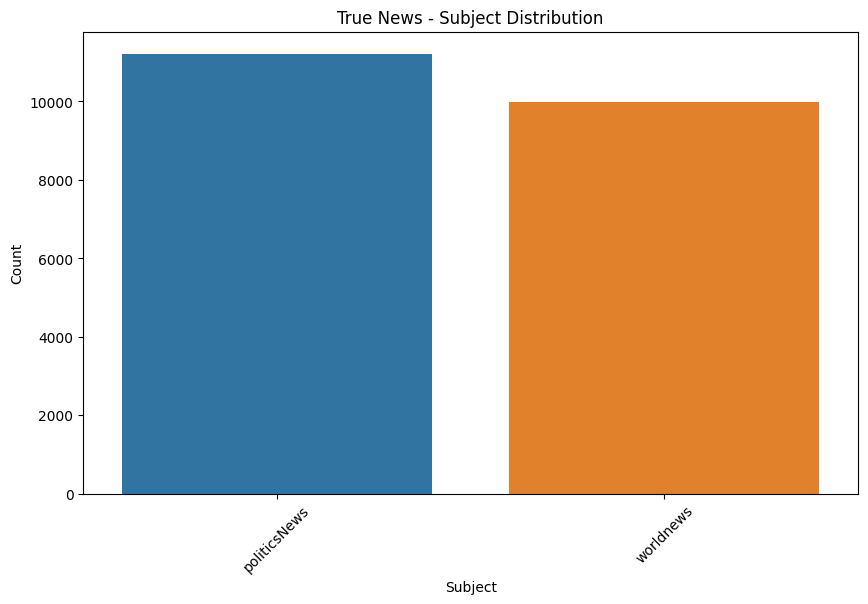

In [125]:
# Subject distribution for true news with vertical bars and two colors
plt.figure(figsize=(10, 6))
sns.countplot(
    x='subject',  # Vertical bar plot
    data=true_news,
    order=true_news['subject'].value_counts().index,
    hue='subject',  
    dodge=False,    
    palette=['#1f77b4', '#ff7f0e']  
)
plt.legend([], [], frameon=False)  
plt.title('True News - Subject Distribution')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.show()

# Before preprocessing

In [126]:
data['text'][1]

'House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained by the New York Times.Former Trump campaign adviser George Papadopoulos was drunk in a wine bar when he revealed knowledge of Russian opposition research on Hillary Clinton.On top of that, Papadopoulos wasn t just a covfefe boy for Trump, as his administration has alleged. He had a much larger role, but none so damning as being a drunken fool in a wine bar. Coffee boys  don t help to arrange a New York meeting between Trump and President Abdel Fattah el-Sisi of Egypt two months before the election. It was known before that the former aide set up meetings with world leaders for Trump, but team Tr

## Preprocessing

In [127]:
# Preprocess text data
def preprocess_text(text):
    # Lowercasing and removing special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    # Removing stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply preprocessing
data['clean_text'] = data['text'].apply(preprocess_text)
data.drop('text', axis=1, inplace=True)

# Randomly sample data to reduce size for faster processing
sampled_data = data.sample(frac=0.1, random_state=42)

# After Preprocessing


In [128]:
data['clean_text'][1]

'house intelligence committee chairman devin nunes going bad day assumption like many us christopher steeledossier prompted russia investigation lashing department justice fbi order protect trump happens dossier started investigation according documents obtained new york timesformer trump campaign adviser george papadopoulos drunk wine bar revealed knowledge russian opposition research hillary clintonon top papadopoulos covfefe boy trump administration alleged much larger role none damning drunken fool wine bar coffee boys help arrange new york meeting trump president abdel fattah elsisi egypt two months election known former aide set meetings world leaders trump team trump ran merely coffee boyin may papadopoulos revealed australian diplomat alexander downer russian officials shopping around possible dirt thendemocratic presidential nominee hillary clinton exactly much mr papadopoulos said night kensington wine rooms australian alexander downer unclear report states two months later l

In [129]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(sampled_data['clean_text'], sampled_data['label'], test_size=0.2, random_state=42)

# Create pipelines for TF-IDF and different classifiers
pipelines = {
    'Logistic Regression': Pipeline([
        ('tfidf', TfidfVectorizer(max_df=0.8, min_df=5, ngram_range=(1, 2))),
        ('classifier', LogisticRegression(solver='liblinear', random_state=42))
    ]),
    'Naive Bayes': Pipeline([
        ('tfidf', TfidfVectorizer(max_df=0.8, min_df=5, ngram_range=(1, 2))),
        ('classifier', MultinomialNB())
    ]),
    'SVM': Pipeline([
        ('tfidf', TfidfVectorizer(stop_words='english')),
        ('classifier', SVC(kernel='linear', random_state=42))
    ])
}

# Train and save each model
for model_name, pipeline in pipelines.items():
    print(f"Training {model_name}...")
    pipeline.fit(X_train, y_train)
    joblib.dump(pipeline, f'{model_name.lower().replace(" ", "_")}_model.pkl')

# Load the models
logistic_model = joblib.load('logistic_regression_model.pkl')
naive_bayes_model = joblib.load('naive_bayes_model.pkl')
svm_model = joblib.load('svm_model.pkl')




Training Logistic Regression...
Training Naive Bayes...
Training SVM...


In [130]:
# Function to evaluate model performance
def evaluate_model(y_true, y_pred, set_name="Set"):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred)

    print(f"--- {set_name} Metrics ---")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    print("\n")

# Function to predict if news is fake or true using traditional ML models
def predict_news(news_text, model):
    preprocessed_input = preprocess_text(news_text)
    prediction = model.predict([preprocessed_input])
    return "Fake News" if prediction[0] == 0 else "True News"

# Evaluate each model on training and test sets
for model_name, model in zip(['Logistic Regression', 'Naive Bayes', 'SVM'], [logistic_model, naive_bayes_model, svm_model]):
    print(f"Evaluating {model_name} on Training Set...")
    evaluate_model(y_train, model.predict(X_train), f"{model_name} Training Set")
    print(f"Evaluating {model_name} on Test Set...")
    evaluate_model(y_test, model.predict(X_test), f"{model_name} Test Set")

# Check for overfitting or underfitting for each model
for model_name, model in zip(['Logistic Regression', 'Naive Bayes', 'SVM'], [logistic_model, naive_bayes_model, svm_model]):
    print(f"Checking overfitting/underfitting for {model_name}...")
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    if train_acc > test_acc + 0.1:
        print(f"{model_name} may be overfitting")
    elif train_acc < 0.6 and test_acc < 0.6:
        print(f"{model_name} may be underfitting")
    else:
        print(f"{model_name} seems to have a good fit")

Evaluating Logistic Regression on Training Set...
--- Logistic Regression Training Set Metrics ---
Accuracy: 0.99
Precision: 0.99
Recall: 0.99
F1 Score: 0.99
Confusion Matrix:
[[1887   19]
 [  15 1654]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1906
           1       0.99      0.99      0.99      1669

    accuracy                           0.99      3575
   macro avg       0.99      0.99      0.99      3575
weighted avg       0.99      0.99      0.99      3575



Evaluating Logistic Regression on Test Set...
--- Logistic Regression Test Set Metrics ---
Accuracy: 0.97
Precision: 0.97
Recall: 0.97
F1 Score: 0.97
Confusion Matrix:
[[461  14]
 [ 11 408]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       475
           1       0.97      0.97      0.97       419

    accuracy                           0.97       894
   macro avg 

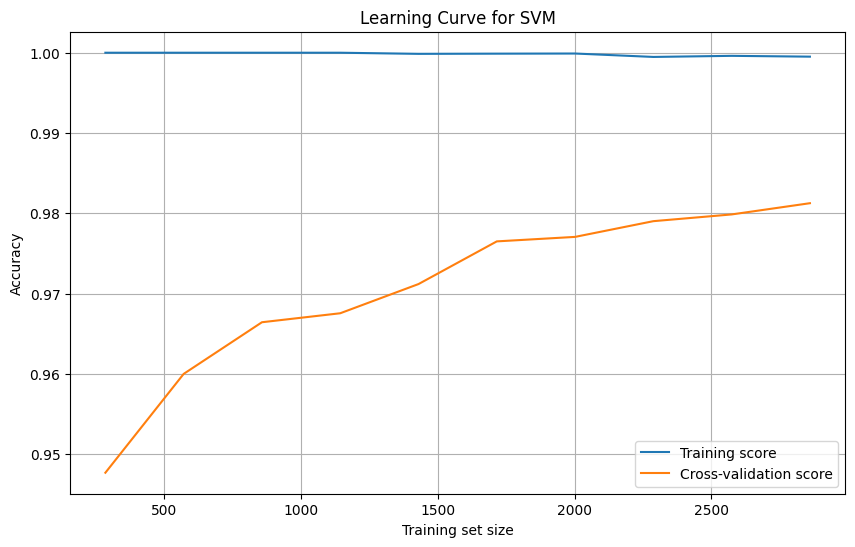

In [131]:
# Generate learning curve for SVM
train_sizes, train_scores, test_scores = learning_curve(
    svm_model, X_train, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score')
plt.title('Learning Curve for SVM')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

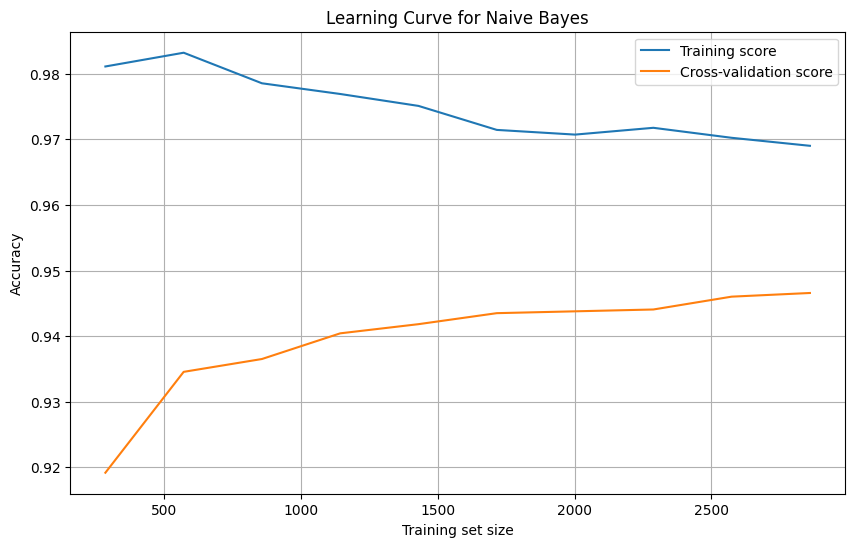

In [133]:
# Naive Bayes Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    naive_bayes_model, X_train, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score')
plt.title('Learning Curve for Naive Bayes')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

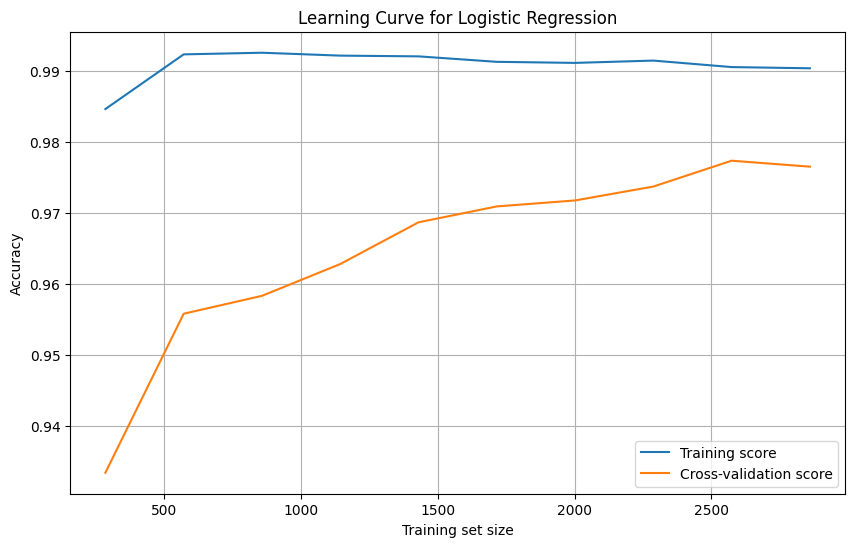

In [134]:
# Learning Curve for Logistic Regression
train_sizes, train_scores, test_scores = learning_curve(
    logistic_model, X_train, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score')
plt.title('Learning Curve for Logistic Regression')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [132]:
# LSTM Model Preparation
print("Preparing LSTM Model...")
max_words = 5000
max_len = 200
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

# Tokenize and pad sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Encode labels
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

# Build LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(max_words, 128, input_length=max_len))
lstm_model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train LSTM model
lstm_model.fit(X_train_pad, y_train_enc, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test_enc))

# Evaluate LSTM model
lstm_loss, lstm_acc = lstm_model.evaluate(X_test_pad, y_test_enc)
print(f"LSTM Model Test Accuracy: {lstm_acc:.2f}")

# Function to predict if news is fake or true using LSTM
def predict_news_lstm(news_text):
    preprocessed_input = preprocess_text(news_text)
    seq = tokenizer.texts_to_sequences([preprocessed_input])
    pad_seq = pad_sequences(seq, maxlen=max_len)
    prediction = lstm_model.predict(pad_seq)
    return "Fake News" if prediction[0] < 0.5 else "True News"

# CNN Model Preparation
print("Preparing CNN Model...")
# Build CNN model
cnn_model = Sequential()
cnn_model.add(Embedding(max_words, 128, input_length=max_len))
cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train CNN model
cnn_model.fit(X_train_pad, y_train_enc, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test_enc))

# Evaluate CNN model
cnn_loss, cnn_acc = cnn_model.evaluate(X_test_pad, y_test_enc)
print(f"CNN Model Test Accuracy: {cnn_acc:.2f}")

# Function to predict if news is fake or true using CNN
def predict_news_cnn(news_text):
    preprocessed_input = preprocess_text(news_text)
    seq = tokenizer.texts_to_sequences([preprocessed_input])
    pad_seq = pad_sequences(seq, maxlen=max_len)
    prediction = cnn_model.predict(pad_seq)
    return "Fake News" if prediction[0] < 0.5 else "True News"

# Test prediction with each model
sample_input = "Trump has already taken to social media to issue orders to Senate Republicans..."
for model_name, model in zip(['Logistic Regression', 'Naive Bayes', 'SVM'], [logistic_model, naive_bayes_model, svm_model]):
    print(f"The news article is predicted to be: {predict_news(sample_input, model)} using {model_name}")

# Test prediction with LSTM model
print(f"The news article is predicted to be: {predict_news_lstm(sample_input)} using LSTM Model")

# Test prediction with CNN model
print(f"The news article is predicted to be: {predict_news_cnn(sample_input)} using CNN Model")

Preparing LSTM Model...
Epoch 1/5


/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.7749 - loss: 0.5376 - val_accuracy: 0.9485 - val_loss: 0.1598
Epoch 2/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 0.9641 - loss: 0.1169 - val_accuracy: 0.9564 - val_loss: 0.1245
Epoch 3/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.9890 - loss: 0.0418 - val_accuracy: 0.9620 - val_loss: 0.1071
Epoch 4/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 0.9929 - loss: 0.0266 - val_accuracy: 0.9597 - val_loss: 0.1124
Epoch 5/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 0.9968 - loss: 0.0173 - val_accuracy: 0.9631 - val_loss: 0.1311
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9689 - loss: 0.0945
LSTM Model Test Accuracy: 0.96
Preparing CNN Model...
Epoch 1/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.6670 - loss: 0.5661 - val_accuracy: 0.9676 - val_loss: 0.0832
Epoch 2/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9919 - loss: 0.0347 - val_accuracy: 0.9799 - val_loss: 0.

Epoch 1/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 8.8865e-04 - val_accuracy: 0.9497 - val_loss: 0.2005
Epoch 2/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 0.9994 - loss: 0.0045 - val_accuracy: 0.9474 - val_loss: 0.2052
Epoch 3/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 0.9995 - loss: 0.0029 - val_accuracy: 0.9519 - val_loss: 0.2035
Epoch 4/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 0.9999 - loss: 5.2862e-04 - val_accuracy: 0.9474 - val_loss: 0.2070
Epoch 5/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 0.9976 - loss: 0.0107 - val_accuracy: 0.9474 - val_loss: 0.2514
Epoch 1/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 1.0000 - loss: 4.0504e-05 - val_accuracy: 0.9799 - val_loss: 0.0913
Epoch 2/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 1.0000 - loss: 3.5504e-05 - val_accuracy: 0.9799 - val_loss: 0.0921
Epoch 3/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 1.0000 - loss: 3.3528e-05 - val_acc

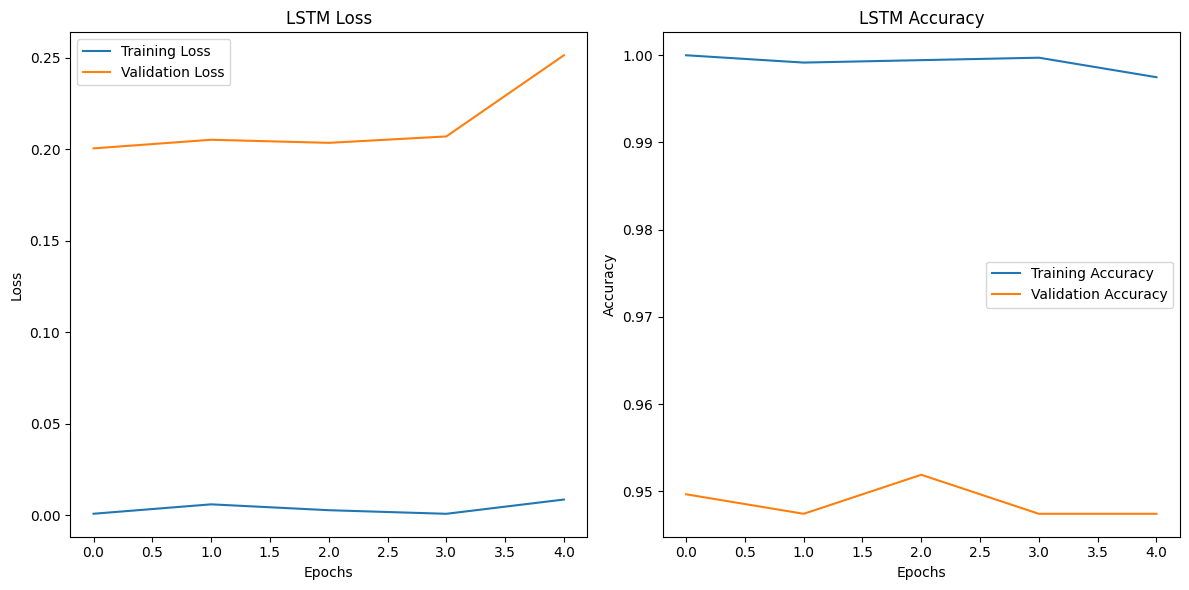

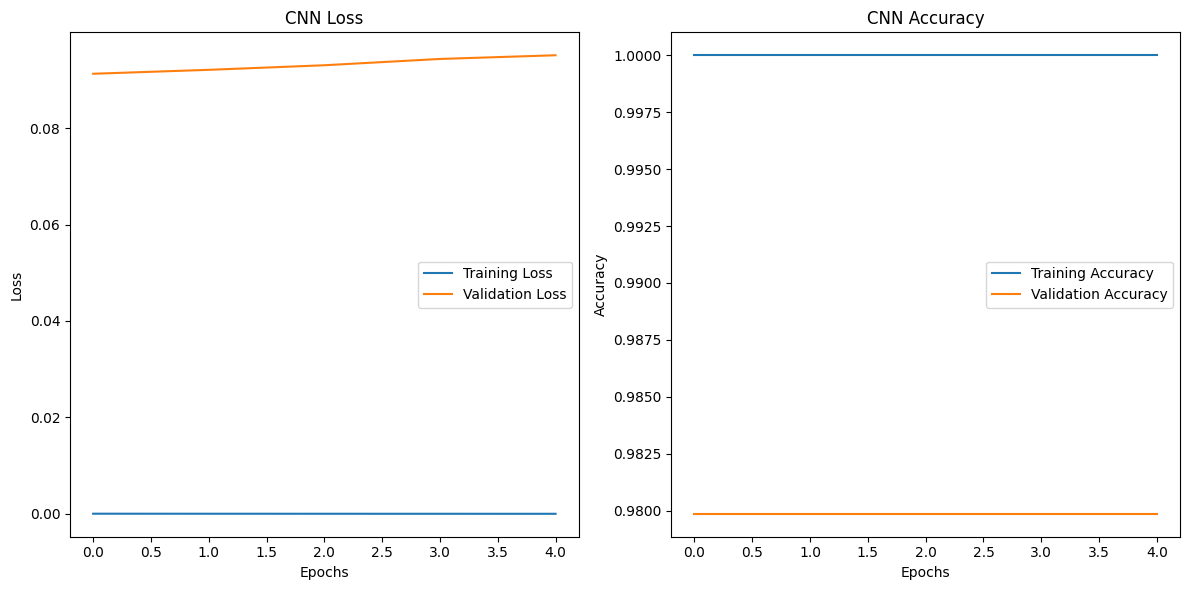

In [136]:
# Train LSTM model and capture training history
lstm_history = lstm_model.fit(
    X_train_pad, 
    y_train_enc, 
    epochs=5, 
    batch_size=64, 
    validation_data=(X_test_pad, y_test_enc)
)

# Train CNN model and capture training history
cnn_history = cnn_model.fit(
    X_train_pad, 
    y_train_enc, 
    epochs=5, 
    batch_size=64, 
    validation_data=(X_test_pad, y_test_enc)
)

# Plot learning curves
def plot_learning_curve(history, model_name):
    plt.figure(figsize=(12, 6))
    
    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot LSTM learning curve
plot_learning_curve(lstm_history, 'LSTM')

# Plot CNN learning curve
plot_learning_curve(cnn_history, 'CNN')
